In [7]:
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from skimage import exposure
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [8]:
base_folder = 'C:/Users/user/OneDrive/Desktop/Animal Image Dataset (90 Different Animals)/animals'

In [9]:
def read_image(base_folder: str, image_size: tuple[int, int]) -> tuple[np.array, np.array]:
    X = []
    y = []
    for label in os.listdir(base_folder):
        label_folder = os.path.join(base_folder, label)
        print(f"Currently reading {label_folder}")
        for image_name in tqdm(os.listdir(label_folder)):
            if image_name.split('.')[-1].lower() in ('jpg', 'png', 'gif'):
                image_path = os.path.join(label_folder, image_name)
                try:
                    image = Image.open(image_path)
                    image = image.convert('RGB')
                    image = image.resize(image_size)
                    X.append(np.array(image))
                    y.append(label)
                except Exception as e:
                    print(f"Error reading {image_path}: {str(e)}")
    X = np.array(X)
    y = np.array(y)
    return X, y


In [10]:
X, y = read_image(base_folder, (128, 128))

Currently reading C:/Users/user/OneDrive/Desktop/Animal Image Dataset (90 Different Animals)/animals\bear


100%|██████████| 60/60 [00:00<00:00, 107.43it/s]


Currently reading C:/Users/user/OneDrive/Desktop/Animal Image Dataset (90 Different Animals)/animals\elephant


100%|██████████| 60/60 [00:00<00:00, 110.35it/s]


Currently reading C:/Users/user/OneDrive/Desktop/Animal Image Dataset (90 Different Animals)/animals\hyena


100%|██████████| 60/60 [00:00<00:00, 89.61it/s]


Currently reading C:/Users/user/OneDrive/Desktop/Animal Image Dataset (90 Different Animals)/animals\okapi


100%|██████████| 60/60 [00:00<00:00, 166.48it/s]


Currently reading C:/Users/user/OneDrive/Desktop/Animal Image Dataset (90 Different Animals)/animals\orangutan


100%|██████████| 60/60 [00:00<00:00, 121.45it/s]


Currently reading C:/Users/user/OneDrive/Desktop/Animal Image Dataset (90 Different Animals)/animals\panda


100%|██████████| 60/60 [00:00<00:00, 193.88it/s]


Currently reading C:/Users/user/OneDrive/Desktop/Animal Image Dataset (90 Different Animals)/animals\rhinoceros


100%|██████████| 60/60 [00:00<00:00, 115.55it/s]


Currently reading C:/Users/user/OneDrive/Desktop/Animal Image Dataset (90 Different Animals)/animals\tiger


100%|██████████| 60/60 [00:00<00:00, 182.92it/s]


In [11]:
# Save the data to a pickle file
output_file = 'data.pickle'
with open(output_file, 'wb') as file:
    pickle.dump((X, y), file)

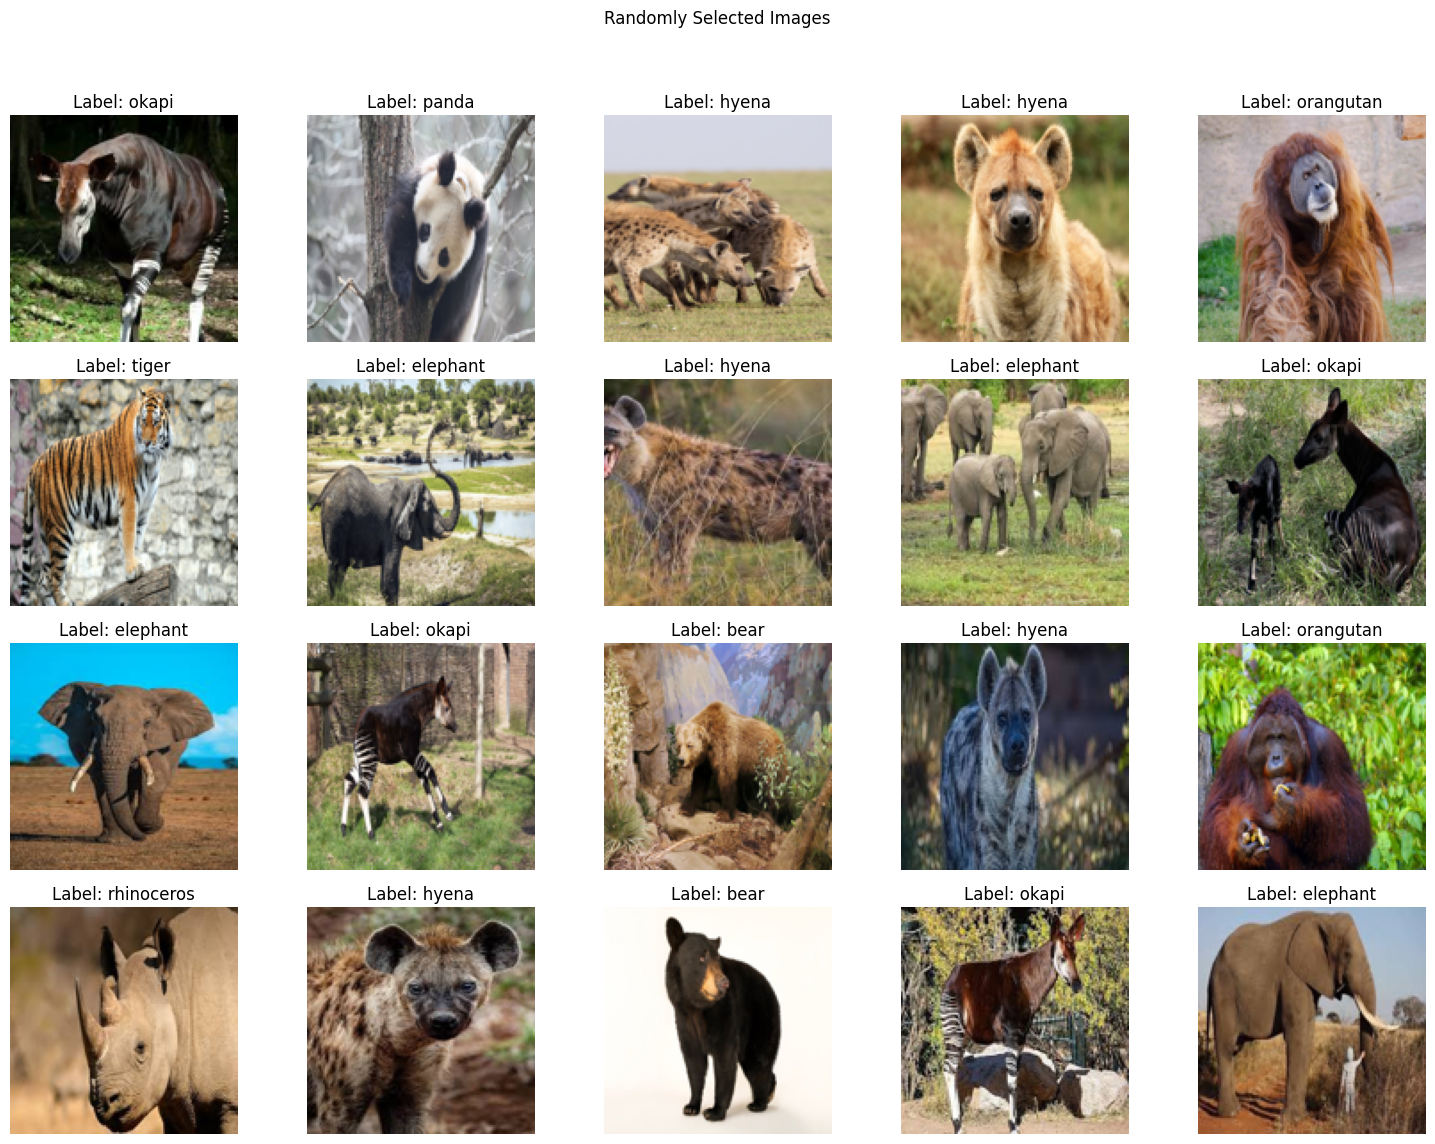

In [12]:
import matplotlib.pyplot as plt
import random

# Load the saved data from the pickle file
with open(output_file, 'rb') as file:
    X, y = pickle.load(file)

# Choose 20 random indices from the dataset
random_indices = random.sample(range(len(X)), 20)

# Plot the selected images
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Randomly Selected Images')

for i, ax in zip(random_indices, axes.flatten()):
    ax.imshow(X[i])  # Assuming the images are grayscale
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [13]:
# Assuming you have already loaded X and y from your pickle file

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the ImageDataGenerator to your training data
datagen.fit(X_train)

# Define the number of augmented images to generate for each original image
num_augmented_images = 5  

# Generate augmented images and append them to X_train
augmented_X_train = []
augmented_y_train = []

for x, y in zip(X_train, y_train):
    x = np.expand_dims(x, axis=0)  # Add batch dimension
    for _ in range(num_augmented_images):
        augmented_img = datagen.flow(x, batch_size=1).next()[0]
        augmented_X_train.append(augmented_img.astype(np.uint8))  # Ensure the datatype is uint8
        augmented_y_train.append(y)

# Convert lists to arrays
augmented_X_train = np.array(augmented_X_train)
augmented_y_train = np.array(augmented_y_train)

# Concatenate augmented images with original X_train and y_train
X_train = np.concatenate([X_train, augmented_X_train], axis=0)
y_train = np.concatenate([y_train, augmented_y_train], axis=0)

# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train)

# Now X_train and y_train contain augmented images along with original images


In [14]:
X_train.shape

(2304, 128, 128, 3)

In [15]:
y_train.shape

(2304,)

In [16]:

# Save y_train as pickle
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

# Save y_test as pickle
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)


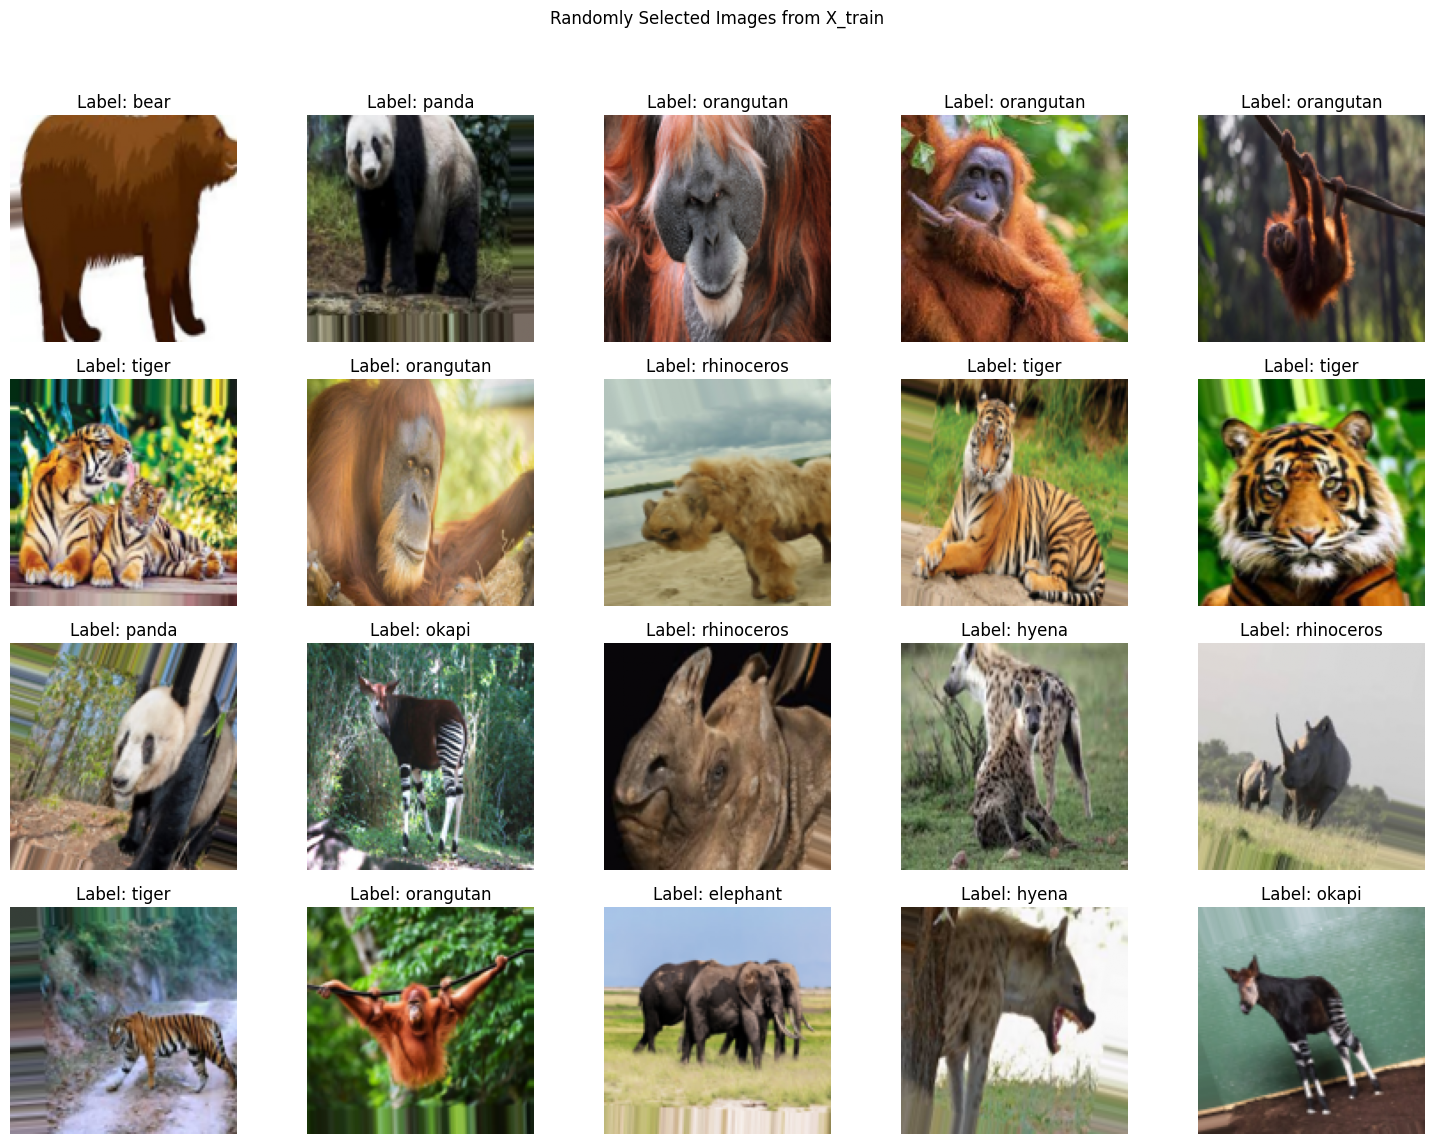

In [17]:


# Choose 20 random indices from the training set
random_indices = random.sample(range(len(X_train)), 20)

# Plot the selected images
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Randomly Selected Images from X_train')

for i, ax in zip(random_indices, axes.flatten()):
    # Normalize the image to [0, 1] range if necessary
    if X_train[i].max() > 1:
        image = X_train[i] / 255.0
    else:
        image = X_train[i]
    ax.imshow(image)  # Assuming the images are RGB
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Feature Extraction using VGG16 on Training Set

In [18]:

# Convert images to PyTorch tensors with appropriate data type
X_tensor = torch.stack([torch.Tensor(img).permute(2, 0, 1).float() for img in X_train])

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        return image

# Transformations for data preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
dataset = CustomDataset(images=X_tensor, transform=transform)

# Create DataLoader instances
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load a pre-trained VGG16 model
pretrained_model = models.vgg16(pretrained=True)
model = nn.Sequential(*list(pretrained_model.children())[:-1])  # Remove the last fully connected layer

# Set the model to evaluation mode
model.eval()

# Extract features
features_list = []
with torch.no_grad():
    for images in data_loader:
        features = model(images)
        features_list.append(features)

# Concatenate features from different batches
all_features = torch.cat(features_list, dim=0)

# Flatten features to a 1D tensor if needed
flattened_features = all_features.view(all_features.size(0), -1)


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:

# Save the variable as a pickle file
with open('all_vgg16.pkl', 'wb') as file:
    pickle.dump(all_features, file)

print("all_features saved as 'all_vgg16.pkl'")

# Save the variable as a pickle file
with open('flattened_vgg16.pkl', 'wb') as file:
    pickle.dump(flattened_features, file)

print("flattened_features saved as 'flattened_vgg16.pkl'")

all_features saved as 'all_vgg16.pkl'
flattened_features saved as 'flattened_vgg16.pkl'


# Feature extraction using VGG 16 on Testing Set

In [20]:
# Convert images to PyTorch tensors with appropriate data type
X_tensor = torch.stack([torch.Tensor(img).permute(2, 0, 1).float() for img in X_test])

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        return image

# Transformations for data preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
dataset = CustomDataset(images=X_tensor, transform=transform)

# Create DataLoader instance
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load a pre-trained VGG16 model
pretrained_model = models.vgg16(pretrained=True)
model = nn.Sequential(*list(pretrained_model.children())[:-1])  # Remove the last fully connected layer

# Set the model to evaluation mode
model.eval()

# Extract features
features_list = []
with torch.no_grad():
    for images in data_loader:
        features = model(images)
        features_list.append(features)

# Concatenate features from different batches
all_features = torch.cat(features_list, dim=0)

# Flatten features to a 1D tensor if needed
flattened_features = all_features.view(all_features.size(0), -1)


In [21]:
# Save the variable as a pickle file
with open('all_vgg16_testing.pkl', 'wb') as file:
    pickle.dump(all_features, file)

print("all_features saved as 'all_vgg16_testing.pkl'")

# Save the variable as a pickle file
with open('flattened_vgg16_testing.pkl', 'wb') as file:
    pickle.dump(flattened_features, file)

print("flattened_features saved as 'flattened_vgg16_testing.pkl'")

all_features saved as 'all_vgg16_testing.pkl'
flattened_features saved as 'flattened_vgg16_testing.pkl'


# Perform efficientNetB2 on Training Set

In [22]:

# Convert images to PyTorch tensors with appropriate data type
X_tensor = torch.stack([torch.Tensor(img).permute(2, 0, 1).float() for img in X_train])

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        return image

# Transformations for data preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
dataset = CustomDataset(images=X_tensor, transform=transform)

# Create DataLoader instances
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load a pre-trained EfficientNetB2 model
pretrained_model = models.efficientnet_b2(pretrained=True)
model = nn.Sequential(*list(pretrained_model.children())[:-1])  # Remove the last fully connected layer

# Set the model to evaluation mode
model.eval()

# Extract features
features_list = []
with torch.no_grad():
    for images in data_loader:
        features = model(images)
        features_list.append(features)

# Concatenate features from different batches
all_features = torch.cat(features_list, dim=0)

# Flatten features to a 1D tensor if needed
flattened_features = all_features.view(all_features.size(0), -1)


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:

# Save the variable as a pickle file
with open('all_efficientnetb2.pkl', 'wb') as file:
    pickle.dump(all_features, file)

print("all_features saved as 'all_efficientnetb2.pkl'")

# Save the variable as a pickle file
with open('flattened_efficientnetb2.pkl', 'wb') as file:
    pickle.dump(flattened_features, file)

print("flattened_features saved as 'flattened_efficientnetb2.pkl'")

all_features saved as 'all_efficientnetb2.pkl'
flattened_features saved as 'flattened_efficientnetb2.pkl'


# Perform EfficientNetB2 on Testing Set

In [24]:
# Convert images to PyTorch tensors with appropriate data type
X_tensor = torch.stack([torch.Tensor(img).permute(2, 0, 1).float() for img in X_test])

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        return image

# Transformations for data preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
dataset = CustomDataset(images=X_tensor, transform=transform)

# Create DataLoader instance
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load a pre-trained EfficientNetB2 model
pretrained_model = models.efficientnet_b2(pretrained=True)
model = nn.Sequential(*list(pretrained_model.children())[:-1])  # Remove the last fully connected layer

# Set the model to evaluation mode
model.eval()

# Extract features
features_list = []
with torch.no_grad():
    for images in data_loader:
        features = model(images)
        features_list.append(features)

# Concatenate features from different batches
all_features = torch.cat(features_list, dim=0)

# Flatten features to a 1D tensor if needed
flattened_features = all_features.view(all_features.size(0), -1)


In [25]:
# Save the variable as a pickle file
with open('all_efficientnetb2_testing.pkl', 'wb') as file:
    pickle.dump(all_features, file)

print("all_features saved as 'all_efficientnetb2_testing.pkl'")

# Save the variable as a pickle file
with open('flattened_efficientnetb2_testing.pkl', 'wb') as file:
    pickle.dump(flattened_features, file)

print("flattened_features saved as 'flattened_efficientnetb2_testing.pkl'")

all_features saved as 'all_efficientnetb2_testing.pkl'
flattened_features saved as 'flattened_efficientnetb2_testing.pkl'


# Perform Training Using extracted feature

## Load and Combine Extracted Feature

In [26]:
# Load flattened features from the second pickle file
with open('flattened_vgg16.pkl', 'rb') as file:
    X_train_extracted1 = pickle.load(file)

# Load flattened features from the second pickle file
with open('flattened_vgg16_testing.pkl', 'rb') as file:
    X_test_extracted1 = pickle.load(file)

# Load flattened features from the second pickle file
with open('flattened_efficientnetb2.pkl', 'rb') as file:
    X_train_extracted2 = pickle.load(file)

# Load flattened features from the second pickle file
with open('flattened_efficientnetb2_testing.pkl', 'rb') as file:
    X_test_extracted2 = pickle.load(file)

X_train_extracted = np.concatenate((X_train_extracted1, X_train_extracted2), axis=1)
X_test_extracted = np.concatenate((X_test_extracted1, X_test_extracted2), axis=1)


In [27]:
# Load y_train
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

# Load y_test
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)
    

In [28]:
# Encode string labels into numerical format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Based on Results, perform random search on LinearSVC

In [35]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [36]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_grid = {
    'C': uniform(loc=0, scale=10),  # Uniform distribution for parameter C
    'loss': ['hinge', 'squared_hinge'],  # Loss function
    'tol': [1e-4, 1e-5, 1e-6],  # Tolerance for stopping criteria
    'class_weight': [None, 'balanced'],  # Set the parameter C of class i to class_weight[i]*C for LinearSVC
    'dual': [True],  
    'penalty': ['l1', 'l2'],  # Penalty term
    'max_iter': [15000, 25000, 35000],  # Maximum number of iterations
    'fit_intercept': [True, False],  # Whether to calculate the intercept for this model
    'intercept_scaling': [1.5, 2.5, 3.5, 4.5],  # Scaling factor for intercept
    'multi_class': ['ovr', 'crammer_singer'],  # Method for multi-class classification
}

# Initialize LinearSVC classifier
linear_svc = LinearSVC()

# Initialize RandomizedSearchCV
linear_svc_random_search = RandomizedSearchCV(estimator=linear_svc, param_distributions=param_grid, n_iter=50, cv=5, random_state = 42)

# Fit RandomizedSearchCV
linear_svc_random_search.fit(X_train_extracted, y_train)

# Print the best parameters found
print("Best parameters found:")
print(linear_svc_random_search.best_params_)

# Get the best parameters
best_params = linear_svc_random_search.best_params_

# Initialize LinearSVC with the best parameters
best_linear_svc = LinearSVC(**best_params)

# Fit the model with the best parameters on the entire training data
best_linear_svc.fit(X_train_extracted, y_train)

# Predictions on the test set
y_pred = best_linear_svc.predict(X_test_extracted)


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\AppData\L

Best parameters found:
{'C': 7.219987722668248, 'class_weight': 'balanced', 'dual': True, 'fit_intercept': False, 'intercept_scaling': 2.5, 'loss': 'squared_hinge', 'max_iter': 15000, 'multi_class': 'ovr', 'penalty': 'l2', 'tol': 1e-05}


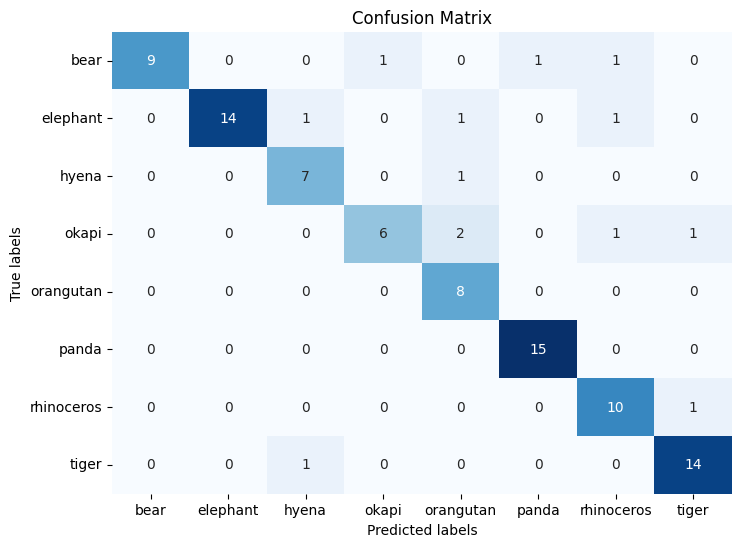

Classification Report:
              precision    recall  f1-score   support

        bear     1.0000    0.7500    0.8571        12
    elephant     1.0000    0.8235    0.9032        17
       hyena     0.7778    0.8750    0.8235         8
       okapi     0.8571    0.6000    0.7059        10
   orangutan     0.6667    1.0000    0.8000         8
       panda     0.9375    1.0000    0.9677        15
  rhinoceros     0.7692    0.9091    0.8333        11
       tiger     0.8750    0.9333    0.9032        15

    accuracy                         0.8646        96
   macro avg     0.8604    0.8614    0.8493        96
weighted avg     0.8831    0.8646    0.8637        96



In [37]:
import seaborn as sns
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))